# Week 8 Practical

In [ ]:
import numpy as np
import nltk
from nltk.corpus import gutenberg
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Concatenate, Flatten
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import plot_model, set_random_seed
import tensorflow as tf
import pandas as pd
import functools
import collections
import math

## A simple classifier using a bag of words

In this practical we will be looking at a dataset called "Symptom2Disease"
from https://www.kaggle.com/datasets/niyarrbarman/symptom2disease

Authors:

- Niyar R Barman
- Faizal Karim
- Krish Sharma

It's not quite real, but it is believable: their methodology was:

> We collected disease symptoms for 24 common diseases. We then used LLMs to convert the
> raw data into natural language description of symptoms.

### Data preparation

The data set is in the same folder as this jupyter notebook, with the name Symptom2Disease.csv

Load it up into a dataframe and view it

In [ ]:
import pandas

df = pandas.read_csv('Symptom2Disease.csv')
df.sample(5)

,Unnamed: 0,label,text
1194,294,diabetes,"My emotions fluctuate, and it's hard for me to..."
122,122,Typhoid,There is a distinct pain in my abdominal part....
14,14,Psoriasis,"My skin is prone to infections due to dry, fla..."
517,217,Arthritis,"My muscles have been really weak, and my neck ..."
465,165,Dimorphic Hemorrhoids,I've been experiencing problems using the rest...


How many different diseases are listed ("label")? Is this a balanced data set?

In [ ]:
print(df.label.unique())
print(df.label.nunique())
print(df.label.value_counts())

['Psoriasis' 'Varicose Veins' 'Typhoid' 'Chicken pox' 'Impetigo' 'Dengue'
 'Fungal infection' 'Common Cold' 'Pneumonia' 'Dimorphic Hemorrhoids'
 'Arthritis' 'Acne' 'Bronchial Asthma' 'Hypertension' 'Migraine'
 'Cervical spondylosis' 'Jaundice' 'Malaria' 'urinary tract infection'
 'allergy' 'gastroesophageal reflux disease' 'drug reaction'
 'peptic ulcer disease' 'diabetes']
24
Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia   

We'll start with a slightly easier problem: instead of predicting the disease specifically, let's
just see whether someone with those symptoms should visit a general practitioner to be treated, or whether
they will end up seeing a specialist.

The diseases that are very common and general practitioner might be able to treat are:

- Common Cold

- Bronchial Asthma

- Hypertension

- Migraine

- Allergy

- Drug Reaction

- Urinary Tract Infection

Update your dataframe with a column "requires_specialist" for the diseases not in that list.

In [ ]:
dermatology_diseases = ['Psoriasis', 'Impetigo', 'Acne']
general_practitioner_diseases = ['Common Cold', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Allergy',
            'Drug Reaction',  'Urinary Tract Infection']
gastroenterology_diseases = ['Gastroesophageal Reflux Disease (GERD)', 'Peptic Ulcer Disease']
infectious_diseases = ['Typhoid', 'Chicken Pox', 'Dengue', 'Fungal Infection', 'Malaria', ]

df['requires_specialist'] = ~df.label.isin(general_practitioner_diseases)

Is it a balanced data set now?

In [ ]:
df.requires_specialist.value_counts()

True     1000
False     200
Name: requires_specialist, dtype: int64

Split the data into training, validation and test data. You can do this by running
`sklearn.model_selection.train_test_split` twice.

In [ ]:
import sklearn.model_selection

pseudo_train, test_data = sklearn.model_selection.train_test_split(df, random_state=12345)
train_data, validation_data = sklearn.model_selection.train_test_split(pseudo_train, random_state=1235)

Create a `keras.layers.TextVectorization` object with `output_mode='tf_idf'`, and `.adapt()` it to
the text of your training data.

In [ ]:
import keras

# In a later exercise students come back here to set max_tokens
vectorizer = keras.layers.TextVectorization(output_mode='tf_idf',# max_tokens=715,
                                            ngrams=2)
vectorizer.adapt(train_data.text)

2023-09-22 15:29:32.786093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Convert your training, validation and test data into TF-IDF vectors using your vectorizer.

In [ ]:
train_vectors = vectorizer(train_data.text)
validation_vectors = vectorizer(validation_data.text)
test_vectors = vectorizer(test_data.text)

### A small logistic regression classifier using Keras

Let's see if we can predict who is going to need a specialist.

We'll use function notation (even though it isn't strictly necessary for this structure).

Create a `keras.Input` object. Its shape should be the size of the vocabulary in your vectorizer.

In [ ]:
inputs = keras.Input(shape=(vectorizer.vocabulary_size()))

Create a `keras.layers.Dense` object to be your output layer, and pass it your input object
as a function argument.

Because there is only one value ("needs a specialist or not"), it should have one neuron, and a sigmoid activation.

In [ ]:
output = keras.layers.Dense(1, activation='sigmoid')(inputs)

Create a `keras.Model` object. `inputs=` the input object; `outputs=` the output layer

In [ ]:
model = keras.Model(inputs=inputs, outputs=output)

### Repeating what you have done in the first half of the course

From here, everything is pretty much the same as every other classifier in the first half of the course.

Compile the model. There are only two classes, so you can use `binary_crossentropy`.

We want to know accuracy, recall, precision and F1 score. F1 score was added in TensorFlow 2.13.0 so if you have
an older version, this might be unavailable to you.

In [ ]:
model.compile(loss='binary_crossentropy', metrics=["accuracy",
                                                   keras.metrics.Precision(),
             keras.metrics.Recall()])

Display a summary of your model.

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7783)]            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7784      
                                                                 
Total params: 7,784
Trainable params: 7,784
Non-trainable params: 0
_________________________________________________________________


Fit the model.

You will need:

- `x` will be your training vectors

- `y` will be the `requires_specialist` column

- `validation_data` will be the same as for training, but using the validation data

- You might want a callback to stop training when the validation loss stops improving.

- You won't need many epochs: it should be less than 100, and they should be quick to run.

Save the history into a variable so that we can look at it.

In [ ]:
history = model.fit(x=train_vectors, y=train_data.requires_specialist,
          validation_data=(validation_vectors,
                          validation_data.requires_specialist),
          callbacks=[keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=3
          )],
          epochs=500
         )

Epoch 1/500
 1/22 [>.............................] - ETA: 10s - loss: 0.6997 - accuracy: 0.5312 - precision: 0.7647 - recall: 0.5417

2023-09-22 15:29:33.752567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.8400 - precision: 0.8847 - recall: 0.9261

2023-09-22 15:29:34.309342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 27ms/step - loss: 0.4250 - accuracy: 0.8400 - precision: 0.8847 - recall: 0.9261 - val_loss: 0.3542 - val_accuracy: 0.9111 - val_precision: 0.9082 - val_recall: 0.9889
Epoch 2/500
22/22 [==============================] - 0s 10ms/step - loss: 0.2038 - accuracy: 0.9526 - precision: 0.9470 - recall: 0.9982 - val_loss: 0.2423 - val_accuracy: 0.9511 - val_precision: 0.9424 - val_recall: 1.0000
Epoch 3/500
22/22 [==============================] - 0s 10ms/step - loss: 0.1188 - accuracy: 0.9852 - precision: 0.9823 - recall: 1.0000 - val_loss: 0.1760 - val_accuracy: 0.9733 - val_precision: 0.9677 - val_recall: 1.0000
Epoch 4/500
22/22 [==============================] - 0s 10ms/step - loss: 0.0718 - accuracy: 0.9985 - precision: 0.9982 - recall: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9822 - val_precision: 0.9783 - val_recall: 1.0000
Epoch 5/500
22/22 [==============================] - 0s 10ms/step - loss: 0.0446 - accuracy: 1.0000 - precision: 1.0

Make a matplotlib chart showing the accuracy and training loss over time.

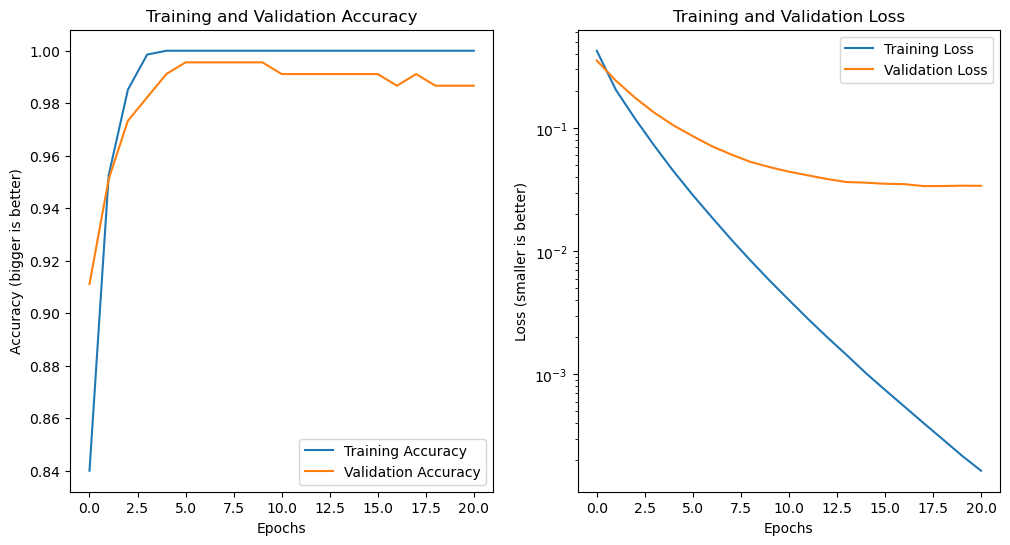

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

Calculate the corpus size, the vocabulary size and their ratio (i.e. the corpus size divided by the vocabulary size).
Based on this and the previous charts, decide whether the model is likely to be overfitting.

In [ ]:
print("Corpus size = ", train_data.shape[0])
print("Vocabulary size =", vectorizer.vocabulary_size())
print("Corpus : vocabulary ratio =",
      train_data.shape[0] / vectorizer.vocabulary_size())

Corpus size =  675
Vocabulary size = 7783
Corpus : vocabulary ratio = 0.08672748297571631


Calculate an appropriate vocabulary size if you only wanted to include words that appeared in the
training data at least 3 times. Go back to where you defined your TextVectorization object and
set `max_tokens` to (this value + 1). It might give you a tiny improvement in your validation scores.

Also try using bigrams. Does this help?

In [ ]:
import nltk
import collections
c = collections.Counter()
for sentence in train_data.text:
    for word in nltk.word_tokenize(sentence):
        c[word.upper()] += 1
vocab_size = sum([1 for x in c.values() if x > 2])
print(vocab_size)

714


Use `.evaluate` on your test data to confirm that your validation results are still close to the test results and
our parameter tuning for validation hasn't altered the results too much.

In [ ]:
print("Test evaluation:")
print(model.evaluate(test_vectors,
                     test_data.requires_specialist,
                     return_dict=True,
                     verbose=0))

Test evaluation:
{'loss': 0.012771002016961575, 'accuracy': 0.996666669845581, 'precision': 0.9962406158447266, 'recall': 1.0}


## Harder task: predicting the actual disease, not just who to go to

Unlike (say) the sklearn classifiers, keras can't work with text labels for classes. Use
`sklearn.preprocessing.LabelEncoder` (or anything else that works for you) to convert the disease labels into integer labels.

You will need to do a train-test split again.

In [ ]:
import sklearn.preprocessing
encoder = sklearn.preprocessing.LabelEncoder()
df['integer_labels'] = encoder.fit_transform(df['label'])
pseudo_train, test_data = sklearn.model_selection.train_test_split(df, random_state=12345)
train_data, validation_data = sklearn.model_selection.train_test_split(pseudo_train, random_state=1235)
vectorizer = keras.layers.TextVectorization(output_mode='tf_idf',# max_tokens=715,
                                            ngrams=2)
vectorizer.adapt(train_data.text)
train_vectors = vectorizer(train_data.text)
validation_vectors = vectorizer(validation_data.text)
test_vectors = vectorizer(test_data.text)

2023-09-22 15:29:39.835099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


You can re-use the existing `keras.Input` since that hasn't changed, or define a new one.
Then create an output layer:

- It will need as many neurons as there are diseases

- Use a 'softmax' activation to normalise the probabilities

And then create a model using those inputs and outputs.

In [ ]:
inputs = keras.Input(shape=(vectorizer.vocabulary_size()))
output = keras.layers.Dense(df.label.nunique(), activation='softmax')(inputs)
model = keras.Model(inputs=inputs, outputs=output)

To compile this model we will need to use `sparse_categorical_crossentropy` as the
loss. Let's use accuracy as the only other metric (we know how to add more if we need to.)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(x=train_vectors, y=train_data.integer_labels,
          validation_data=(validation_vectors,
                          validation_data.integer_labels),
          callbacks=[keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=30
          )],
          epochs=500
         )

Epoch 1/500
10/22 [============>.................] - ETA: 0s - loss: 2.7868 - accuracy: 0.2781

2023-09-22 15:29:40.562414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 13ms/step - loss: 2.3778 - accuracy: 0.4519 - val_loss: 1.7454 - val_accuracy: 0.6311
Epoch 2/500
11/22 [==============>...............] - ETA: 0s - loss: 0.9347 - accuracy: 0.9688

2023-09-22 15:29:40.860680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 7ms/step - loss: 0.8290 - accuracy: 0.9778 - val_loss: 1.1302 - val_accuracy: 0.7467
Epoch 3/500
22/22 [==============================] - 0s 7ms/step - loss: 0.3198 - accuracy: 1.0000 - val_loss: 0.8245 - val_accuracy: 0.8267
Epoch 4/500
22/22 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 1.0000 - val_loss: 0.6437 - val_accuracy: 0.8578
Epoch 5/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 0.9022
Epoch 6/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.4279 - val_accuracy: 0.9067
Epoch 7/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.3589 - val_accuracy: 0.9111
Epoch 8/500
22/22 [==============================] - 0s 7ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3092 - val_accuracy: 0.9244
Epoch 9/500
22/22 [======

22/22 [==============================] - 0s 7ms/step - loss: 2.2252e-08 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 0.9644
Epoch 59/500
22/22 [==============================] - 0s 7ms/step - loss: 1.9780e-08 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 0.9644
Epoch 60/500
22/22 [==============================] - 0s 6ms/step - loss: 1.9250e-08 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9644
Epoch 61/500
22/22 [==============================] - 0s 6ms/step - loss: 1.8367e-08 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9644
Epoch 62/500
22/22 [==============================] - 0s 6ms/step - loss: 1.6778e-08 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9644
Epoch 63/500
22/22 [==============================] - 0s 7ms/step - loss: 1.5718e-08 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy: 0.9644
Epoch 64/500
22/22 [==============================] - 0s 7ms/step - loss: 1.4305e-08 - accuracy: 1.0000 - val_loss: 0.1183 - val_accuracy

Plot the accuracy and loss for the training data and validation data

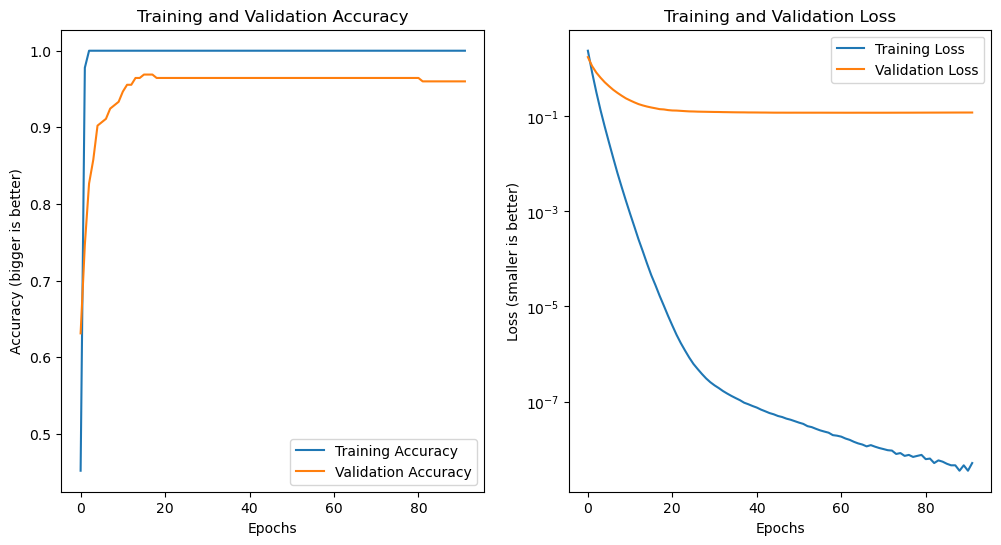

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

It's less obvious how to improve this model now, but we do have fairly good accuracy anyway.

Confirm that the accuracy is also quite good on the test data.

In [ ]:
print("Test evaluation:")
print(model.evaluate(test_vectors,
                     test_data.integer_labels,
                     return_dict=True,
                     verbose=0))

Test evaluation:
{'loss': 0.15425623953342438, 'accuracy': 0.9466666579246521}


## Free-form

Try to optimise the model by adding extra layers, modifying the vocabulary or any other ideas you want to try out.

Dropout often helps (try 0.9 or higher).

In [ ]:
# Adding a few extra layers and some n-grams would help if we were underfitting...
think_vectorizer = keras.layers.TextVectorization(output_mode='tf_idf', ngrams=2, max_tokens=vocab_size)
think_vectorizer.adapt(train_data.text)
think_inputs = keras.Input(shape=(think_vectorizer.vocabulary_size(),))
train_vectors = think_vectorizer(train_data.text)
validation_vectors = think_vectorizer(validation_data.text)
test_vectors = think_vectorizer(test_data.text)
think_layer = keras.layers.Dense(96, activation='softmax')(think_inputs)
dropsies  = keras.layers.Dropout(0.95)(think_layer)
second_thinking_layer = keras.layers.Dense(48, activation='softmax')(dropsies)
think_output = keras.layers.Dense(df.label.nunique(), activation='softmax')(second_thinking_layer)
model = keras.Model(inputs=think_inputs, outputs=think_output)
model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(x=train_vectors, y=train_data.integer_labels,
          validation_data=(validation_vectors,
                          validation_data.integer_labels),
          epochs=500
         )

2023-09-22 15:29:54.764484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/500


2023-09-22 15:29:55.562825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 18ms/step - loss: 3.1797 - accuracy: 0.0326 - val_loss: 3.1785 - val_accuracy: 0.0489
Epoch 2/500
 8/22 [=========>....................] - ETA: 0s - loss: 3.1772 - accuracy: 0.0312    

2023-09-22 15:29:56.068854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 10ms/step - loss: 3.1779 - accuracy: 0.0563 - val_loss: 3.1788 - val_accuracy: 0.0267
Epoch 3/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1770 - accuracy: 0.0578 - val_loss: 3.1790 - val_accuracy: 0.0267
Epoch 4/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1753 - accuracy: 0.0563 - val_loss: 3.1792 - val_accuracy: 0.0267
Epoch 5/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1739 - accuracy: 0.0637 - val_loss: 3.1791 - val_accuracy: 0.0267
Epoch 6/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1721 - accuracy: 0.0578 - val_loss: 3.1791 - val_accuracy: 0.0267
Epoch 7/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1698 - accuracy: 0.0681 - val_loss: 3.1792 - val_accuracy: 0.0267
Epoch 8/500
22/22 [==============================] - 0s 9ms/step - loss: 3.1702 - accuracy: 0.0578 - val_loss: 3.1792 - val_accuracy: 0.0267
Epoch 9/500
22/22 [=====

Epoch 60/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0904 - accuracy: 0.0859 - val_loss: 3.1724 - val_accuracy: 0.0267
Epoch 61/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0827 - accuracy: 0.0919 - val_loss: 3.1718 - val_accuracy: 0.0267
Epoch 62/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0894 - accuracy: 0.0830 - val_loss: 3.1716 - val_accuracy: 0.0267
Epoch 63/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0953 - accuracy: 0.0844 - val_loss: 3.1708 - val_accuracy: 0.0267
Epoch 64/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0924 - accuracy: 0.0815 - val_loss: 3.1703 - val_accuracy: 0.0267
Epoch 65/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0763 - accuracy: 0.0993 - val_loss: 3.1696 - val_accuracy: 0.0267
Epoch 66/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0674 - accuracy: 0.0948 - val_loss: 3.1691 - val_accuracy: 0.0267
Epoch 

22/22 [==============================] - 0s 9ms/step - loss: 3.0055 - accuracy: 0.0919 - val_loss: 3.1270 - val_accuracy: 0.0978
Epoch 118/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0056 - accuracy: 0.0933 - val_loss: 3.1268 - val_accuracy: 0.0978
Epoch 119/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9879 - accuracy: 0.0904 - val_loss: 3.1256 - val_accuracy: 0.0978
Epoch 120/500
22/22 [==============================] - 0s 9ms/step - loss: 3.0050 - accuracy: 0.0785 - val_loss: 3.1253 - val_accuracy: 0.0978
Epoch 121/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9995 - accuracy: 0.0948 - val_loss: 3.1239 - val_accuracy: 0.0978
Epoch 122/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9986 - accuracy: 0.0815 - val_loss: 3.1226 - val_accuracy: 0.0978
Epoch 123/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9906 - accuracy: 0.0948 - val_loss: 3.1202 - val_accuracy: 0.0978
Epoch 124/500

22/22 [==============================] - 0s 9ms/step - loss: 2.9122 - accuracy: 0.0978 - val_loss: 3.0598 - val_accuracy: 0.0978
Epoch 175/500
22/22 [==============================] - 0s 9ms/step - loss: 2.8855 - accuracy: 0.1052 - val_loss: 3.0592 - val_accuracy: 0.0978
Epoch 176/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9072 - accuracy: 0.1185 - val_loss: 3.0536 - val_accuracy: 0.0978
Epoch 177/500
22/22 [==============================] - 0s 9ms/step - loss: 2.8994 - accuracy: 0.1111 - val_loss: 3.0545 - val_accuracy: 0.0978
Epoch 178/500
22/22 [==============================] - 0s 9ms/step - loss: 2.8849 - accuracy: 0.1052 - val_loss: 3.0554 - val_accuracy: 0.0978
Epoch 179/500
22/22 [==============================] - 0s 9ms/step - loss: 2.8802 - accuracy: 0.1244 - val_loss: 3.0585 - val_accuracy: 0.0978
Epoch 180/500
22/22 [==============================] - 0s 9ms/step - loss: 2.9040 - accuracy: 0.1067 - val_loss: 3.0508 - val_accuracy: 0.0978
Epoch 181/500

22/22 [==============================] - 0s 9ms/step - loss: 2.7753 - accuracy: 0.1348 - val_loss: 2.9864 - val_accuracy: 0.1333
Epoch 232/500
22/22 [==============================] - 0s 9ms/step - loss: 2.8038 - accuracy: 0.1111 - val_loss: 2.9849 - val_accuracy: 0.1333
Epoch 233/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7813 - accuracy: 0.1244 - val_loss: 2.9813 - val_accuracy: 0.1333
Epoch 234/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7789 - accuracy: 0.1141 - val_loss: 2.9787 - val_accuracy: 0.1333
Epoch 235/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7579 - accuracy: 0.1526 - val_loss: 2.9801 - val_accuracy: 0.1378
Epoch 236/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7788 - accuracy: 0.1511 - val_loss: 2.9741 - val_accuracy: 0.1422
Epoch 237/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7712 - accuracy: 0.1230 - val_loss: 2.9780 - val_accuracy: 0.1422
Epoch 238/500

22/22 [==============================] - 0s 9ms/step - loss: 2.6609 - accuracy: 0.1348 - val_loss: 2.9357 - val_accuracy: 0.1511
Epoch 289/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6977 - accuracy: 0.1215 - val_loss: 2.9342 - val_accuracy: 0.1422
Epoch 290/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6612 - accuracy: 0.1452 - val_loss: 2.9387 - val_accuracy: 0.1467
Epoch 291/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7079 - accuracy: 0.1230 - val_loss: 2.9380 - val_accuracy: 0.1511
Epoch 292/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6658 - accuracy: 0.1304 - val_loss: 2.9505 - val_accuracy: 0.1289
Epoch 293/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7123 - accuracy: 0.1319 - val_loss: 2.9454 - val_accuracy: 0.1333
Epoch 294/500
22/22 [==============================] - 0s 9ms/step - loss: 2.7379 - accuracy: 0.1215 - val_loss: 2.9477 - val_accuracy: 0.1600
Epoch 295/500

22/22 [==============================] - 0s 9ms/step - loss: 2.6534 - accuracy: 0.1333 - val_loss: 2.9584 - val_accuracy: 0.1511
Epoch 346/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6866 - accuracy: 0.1348 - val_loss: 2.9649 - val_accuracy: 0.1511
Epoch 347/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6394 - accuracy: 0.1363 - val_loss: 2.9672 - val_accuracy: 0.1556
Epoch 348/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6142 - accuracy: 0.1481 - val_loss: 2.9572 - val_accuracy: 0.1467
Epoch 349/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6410 - accuracy: 0.1259 - val_loss: 2.9610 - val_accuracy: 0.1467
Epoch 350/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6499 - accuracy: 0.1407 - val_loss: 2.9633 - val_accuracy: 0.1556
Epoch 351/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6472 - accuracy: 0.1363 - val_loss: 2.9673 - val_accuracy: 0.1422
Epoch 352/500

22/22 [==============================] - 0s 9ms/step - loss: 2.6250 - accuracy: 0.1511 - val_loss: 3.0163 - val_accuracy: 0.1067
Epoch 403/500
22/22 [==============================] - 0s 10ms/step - loss: 2.6035 - accuracy: 0.1481 - val_loss: 3.0195 - val_accuracy: 0.1156
Epoch 404/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6147 - accuracy: 0.1511 - val_loss: 3.0276 - val_accuracy: 0.1200
Epoch 405/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6170 - accuracy: 0.1585 - val_loss: 3.0198 - val_accuracy: 0.1111
Epoch 406/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6217 - accuracy: 0.1585 - val_loss: 3.0209 - val_accuracy: 0.1111
Epoch 407/500
22/22 [==============================] - 0s 9ms/step - loss: 2.5583 - accuracy: 0.1570 - val_loss: 3.0188 - val_accuracy: 0.1244
Epoch 408/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6046 - accuracy: 0.1333 - val_loss: 3.0304 - val_accuracy: 0.1156
Epoch 409/50

22/22 [==============================] - 0s 9ms/step - loss: 2.5915 - accuracy: 0.1556 - val_loss: 3.0931 - val_accuracy: 0.1111
Epoch 460/500
22/22 [==============================] - 0s 9ms/step - loss: 2.5414 - accuracy: 0.1615 - val_loss: 3.1020 - val_accuracy: 0.1244
Epoch 461/500
22/22 [==============================] - 0s 9ms/step - loss: 2.5622 - accuracy: 0.1704 - val_loss: 3.1017 - val_accuracy: 0.1067
Epoch 462/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6222 - accuracy: 0.1452 - val_loss: 3.0978 - val_accuracy: 0.1111
Epoch 463/500
22/22 [==============================] - 0s 9ms/step - loss: 2.5962 - accuracy: 0.1570 - val_loss: 3.0959 - val_accuracy: 0.1200
Epoch 464/500
22/22 [==============================] - 0s 9ms/step - loss: 2.5921 - accuracy: 0.1526 - val_loss: 3.0991 - val_accuracy: 0.1289
Epoch 465/500
22/22 [==============================] - 0s 9ms/step - loss: 2.6161 - accuracy: 0.1467 - val_loss: 3.1045 - val_accuracy: 0.1111
Epoch 466/500

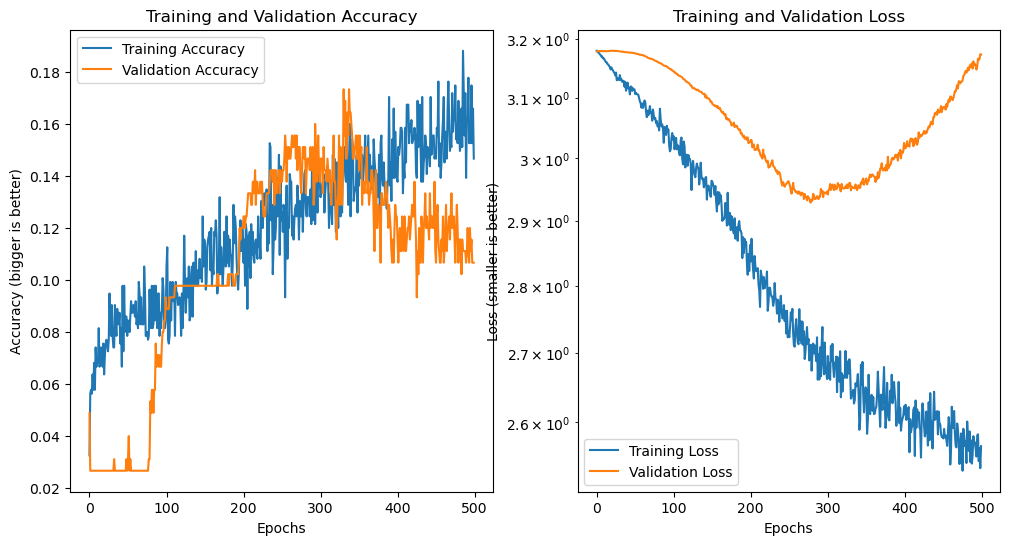

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].plot(history.history['accuracy'],
        label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'],
        label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy (bigger is better)')
axes[0].legend()


axes[1].plot(history.history['loss'],
        label='Training Loss')
axes[1].plot(history.history['val_loss'],
        label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss (smaller is better)')
axes[1].legend()
axes[1].set_yscale('log')

In [ ]:
print(model.evaluate(test_vectors,
                     test_data.integer_labels,
                     return_dict=True,
                     verbose=0))

{'loss': 3.185762405395508, 'accuracy': 0.11999999731779099}


## Lexico-statistical analysis

The following functions will be helpful in this exercise. The first two are taken from the `shakespeare.py`
file from the lecture.

In [ ]:
@functools.lru_cache(100)
def tokenize_document(doc):
    return nltk.word_tokenize(doc.decode('utf-8'))

@functools.lru_cache(100)
def sentence_split_document(doc):
    return nltk.sent_tokenize(doc.decode('utf-8'))


@functools.lru_cache(1000)
def herdan_coefficients(doc):
    vocab_so_far = set()
    vocab_sizes = []
    word_counts = []
    log_word_counts = []
    log_vocab_sizes = []
    for i,w in enumerate(tokenize_document(doc)):
        vocab_so_far.update([w])
        vocab_sizes.append(len(vocab_so_far))
        word_counts.append(i+1)
        log_word_counts.append(math.log10(i+1))
        log_vocab_sizes.append(math.log10(len(vocab_so_far)))
    beta, log_k = np.polyfit(log_word_counts, log_vocab_sizes, 1)
    k = 10**log_k
    return k

There is a program `shakespeare.py` in the zip file of programs associated with this week's lecture. There's
a copy of it in the practical folder too.

Use that as base (feel free to copy it as-is) and make the following changes:

1. An easy starter. Note that hapax_count is disconnected from the graph. The outputs don't depend on it in any way right now. Fix this, and see if that improves the accuracy and how quickly it learns.

2. Replace all the `tf.int32` types with `tf.float32`. You will need to `tf.cast` in `count_letters`.

3. Add Herdan's Law coefficients to the concatenated layers. The `herdan_coefficients` function above acts on
actual values (it doesn't set up a computation graph) and has no meaningful derivative, so it will need to be
wrapped in to function with EagerTensors, similarly to `count_words` or `count_distinct_words`.

4. (Optional/extension) How would you modify this program to detect your writing (vs something written by someone else).

In [ ]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /Users/gregb/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [ ]:
# Create a dataframe with the text of some Gutenberg documents,
# and whether that document was written by Shakespeare or not
documents = pd.DataFrame({'fileid': gutenberg.fileids()})
documents['text'] = documents.fileid.map(gutenberg.raw)
documents['shakespeare'] = documents.fileid.str.contains('shakespeare')
documents.set_index('fileid', inplace=True)

# The usual, train-test split. There aren't many documents
# in the dataset that were written by Shakespeare, so let's
# make sure that there are some in both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    documents[['text']], documents.shakespeare,
    stratify=documents.shakespeare)


# Tensorflow doesn't know that word counts won't change
# over time. But we do, so we can cache this information
# for major speed improvements.


# These functions operate on an EagerTensor, which
# exists in *eager* execution mode, which
# means that there is no execution graph being
# created.
# These functions are very similar. I wrote it like
# this to be easy to debug and understand. It's
# not very efficient.
def count_words(x):
    n = x.numpy()
    answer = np.zeros(np.shape(n))
    for i in range(n.shape[0]):
        document = n[i, 0]
        tokens = tokenize_document(document)
        word_count = len(tokens)
        answer[i, 0] = word_count
    return answer

def count_distinct_words(x):
    n = x.numpy()
    answer = np.zeros(np.shape(n))
    for i in range(n.shape[0]):
        document = n[i, 0]
        tokens = tokenize_document(document)
        word_count = len(set(tokens))
        answer[i, 0] = word_count
    return answer

def count_sentences(x):
    n = x.numpy()
    answer = np.zeros(np.shape(n))
    for i in range(n.shape[0]):
        document = n[i, 0]
        tokens = sentence_split_document(document)
        word_count = len(tokens)
        answer[i, 0] = word_count
    return answer

def herdan(x):
    n = x.numpy()
    answer = np.zeros(np.shape(n))
    for i in range(n.shape[0]):
        document = n[i, 0]
        answer[i, 0] = herdan_coefficients(document)
    tf.print(answer)
    return answer

def count_hapax_legomena(x):
    n = x.numpy()
    answer = np.zeros(np.shape(n))
    for i in range(n.shape[0]):
        document = n[i, 0]
        tokens = tokenize_document(document)
        counter = collections.Counter(tokens)
        hapax_legomena = [
            word for word, count
            in counter.items()
            if count == 1]
        answer[i, 0] = len(hapax_legomena)
    return answer


# The following functions can operate on
# any kind of Tensor: either an EagerTensor
# or a LazyTensor. LazyTensors can use
# hardware backends for optimisations.
def compute_number_of_words(x):
    tt = tf.py_function(func=count_words,
                        inp=[x],
                        Tout=tf.float32)
    tt.set_shape(x.get_shape().as_list())
    return tt


def compute_number_of_distinct_words(x):
    tt = tf.py_function(func=count_distinct_words,
                        inp=[x],
                        Tout=tf.float32)
    tt.set_shape(x.get_shape().as_list())
    return tt

def compute_number_of_sentences(x):
    tt = tf.py_function(func=count_sentences,
                        inp=[x],
                        Tout=tf.float32)
    tt.set_shape(x.get_shape().as_list())
    return tt

def compute_hapax_legomena(x):
    tt = tf.py_function(func=count_hapax_legomena,
                        inp=[x],
                        Tout=tf.float32)
    tt.set_shape(x.get_shape().as_list())
    return tt

def compute_herdan(x):
    tt = tf.py_function(func=count_hapax_legomena,
                        inp=[x],
                        Tout=tf.float32)
    tt.set_shape(x.get_shape().as_list())
    return tt

# Now let's do something a bit more complicated.
# Notice that this function only uses tensorflow
# functions. So this can operate on an EagerTensor
# or a LazyTensor, and can be optimised on GPUs.
def count_letters(tensor):
    count = tf.strings.length(tensor, unit="UTF8_CHAR")
    return tf.cast(count, tf.float32)

In [ ]:
# First, there are the inputs. Those are strings (the
# text of the document)
inputs = Input(shape=(1,), dtype=tf.string)

# Now we want to process those strings and extract
# out interesting lexico-statistics. A Lambda layer
# is something that calls a function; that function
# must take a LazyTensor as an argument.

sentence_count = Lambda(compute_number_of_sentences,
    name="sentence_count")(inputs)
word_count = Lambda(compute_number_of_words,
    name="word_count")(inputs)

distinct_word_count = Lambda(
    compute_number_of_distinct_words,
    name="distinct_word_count")(inputs)

hapax_count = Lambda(
    compute_hapax_legomena,
    name="hapax_legomena")(inputs)

letter_count_layer = Lambda(
    count_letters,
    name="letter_count")(inputs)

herdan_layer = Lambda(compute_herdan, name='herdan')(inputs)

herdan_flattened = Flatten()(herdan_layer)

concatenated = Concatenate(axis=1)(
    [sentence_count,
     word_count,
     distinct_word_count,
     hapax_count,
     herdan_layer,
     letter_count_layer])
merged = Dense(32, activation='relu')(concatenated)
outputs = Dense(1, activation='sigmoid', name="final_output")(merged)
model = Model(inputs=[inputs], outputs=[outputs])

Metal device set to: Apple M1


2023-09-22 15:28:42.203399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 15:28:42.203478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 sentence_count (Lambda)        (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 word_count (Lambda)            (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 distinct_word_count (Lambda)   (None, 1)            0           ['input_1[0][0]']                
                                                                                              

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    restore_best_weights=True)

# I have a large split for validation so that I'm likely
# to see some Shakespeare texts in the validation data too.
# I could have ensured this in other ways, but I chose not to.
# It's a small job, so I can afford to train for a lot of
# epochs; and to get good accuracy, I need to.
model.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_split=0.5, callbacks=[early_stopping])

Epoch 1/1000


2023-09-22 15:28:42.344339: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-22 15:28:42.506435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 115319.2734 - accuracy: 0.0000e+00

2023-09-22 15:28:44.921137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 115319.2734 - accuracy: 0.0000e+00 - val_loss: 121961.4375 - val_accuracy: 0.2857
Epoch 2/1000
1/1 [==============================] - 0s 175ms/step - loss: 113372.2188 - accuracy: 0.0000e+00 - val_loss: 119870.9375 - val_accuracy: 0.2857
Epoch 3/1000
1/1 [==============================] - 0s 174ms/step - loss: 111427.0703 - accuracy: 0.0000e+00 - val_loss: 117782.5391 - val_accuracy: 0.2857
Epoch 4/1000
1/1 [==============================] - 0s 173ms/step - loss: 109483.8984 - accuracy: 0.0000e+00 - val_loss: 115696.3125 - val_accuracy: 0.2857
Epoch 5/1000
1/1 [==============================] - 0s 174ms/step - loss: 107542.7266 - accuracy: 0.0000e+00 - val_loss: 113612.2500 - val_accuracy: 0.2857
Epoch 6/1000
1/1 [==============================] - 0s 175ms/step - loss: 105603.5859 - accuracy: 0.0000e+00 - val_loss: 111530.3594 - val_accuracy: 0.2857
Epoch 7/1000
1/1 [==============================] - 0s 174ms/step - loss: 103666

Epoch 54/1000
1/1 [==============================] - 0s 183ms/step - loss: 14210.5430 - accuracy: 0.0000e+00 - val_loss: 13336.4736 - val_accuracy: 0.2857
Epoch 55/1000
1/1 [==============================] - 0s 176ms/step - loss: 12307.4766 - accuracy: 0.0000e+00 - val_loss: 11288.8457 - val_accuracy: 0.2857
Epoch 56/1000
1/1 [==============================] - 0s 174ms/step - loss: 10402.4385 - accuracy: 0.0000e+00 - val_loss: 9238.9346 - val_accuracy: 0.2857
Epoch 57/1000
1/1 [==============================] - 0s 174ms/step - loss: 8495.2783 - accuracy: 0.0000e+00 - val_loss: 7186.6064 - val_accuracy: 0.2857
Epoch 58/1000
1/1 [==============================] - 0s 173ms/step - loss: 6585.8613 - accuracy: 0.0000e+00 - val_loss: 5131.6753 - val_accuracy: 0.2857
Epoch 59/1000
1/1 [==============================] - 0s 173ms/step - loss: 4674.0229 - accuracy: 0.0000e+00 - val_loss: 3076.9910 - val_accuracy: 0.1429
Epoch 60/1000
1/1 [==============================] - 0s 174ms/step - loss: 27

Epoch 161: early stopping


In [ ]:
# So how did we do?

predictions = pd.Series(index=X_test.index,
                        data=model.predict(X_test)[:,0])
print(f"Predictions:\n", predictions)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on held-out test data: {accuracy * 100:.2f}%")

2023-09-22 15:29:15.355254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 17s 17s/step
Predictions:
 fileid
chesterton-thursday.txt    0.0
bible-kjv.txt              1.0
melville-moby_dick.txt     0.0
shakespeare-caesar.txt     0.0
chesterton-ball.txt        0.0
dtype: float32
1/1 [==============================] - 0s 229ms/step - loss: 209.9941 - accuracy: 0.6000
Accuracy on held-out test data: 60.00%
